In [84]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import utilities.data_utils as utility
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

# Neural Network

For the neural network we will use the `downsampled_df` that was created from the experiments on Linear Regression

In [85]:
# read the dataset
df = pd.read_csv("data/downsampled_df.csv")
df.head()

,Unnamed: 0,description,annual_salary
0,0,Employment Type Regular Location ESCONDIDO CA ...,46870.0
1,1,Roessel Joy partnered health services company ...,44000.0
2,2,Description Overview Starting Pay hour Additio...,31000.0
3,3,Company Description Headquartered Southern Cal...,42560.0
4,4,Posting Details Job Title Child Life Specialis...,49090.0


To run experiments with neural networks, we create a generic function that allows us to easily change the configuration of the network. We abstract the input shape, number of hidden layers, the hidden units in each layer, and the activation function for each layer

In [86]:
# define the function for FFN in order to change the parameters easily
def create_ffn(input_shape, num_layers, hidden_units, activation_function):
    """
    Create a Feedforward Neural Network with customizable architecture.

    Parameters:
    - input_shape: Tuple representing the shape of the input data.
    - num_layers: Integer, the number of hidden layers in the network.
    - hidden_units: List of integers, each representing the number of units in each hidden layer.
    - activation_function: String representing the activation function for each hidden layer.

    Returns:
    - model: A Keras Sequential model with the specified architecture.
    """

    # Initialize the model
    model = Sequential()

    # Add the input layer
    model.add(Dense(hidden_units[0], activation=activation_function, input_shape=input_shape))

    # Add hidden layers
    for i in range(1, num_layers):
        model.add(Dense(hidden_units[i], activation=activation_function))

    # Add output layer
    model.add(Dense(1))  # Assuming a single output unit for a regression task

    return model

## TF-IDF

Based on the experiments with linear regression, we will only use TF-IDF vectorization for the neural network, with a `max_df` of .25

In [87]:
tfidf = TfidfVectorizer(max_df = .25, min_df = 1)

X = tfidf.fit_transform(df['description']).toarray()
y = df['annual_salary'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Here we verify a vocabulary was created, by checking the size of the vocabulary, and a sample of the first five tokens

In [88]:
vocab_size = len(tfidf.vocabulary_)
print("Size of vocabulary:", vocab_size)
print(list(tfidf.vocabulary_.keys())[0:5])

Size of vocabulary: 38774
['type', 'regular', 'escondido', 'ca', 'ever']


Then we build our first example of a neural network, with four hidden layers with unit size of 64, 128, 32, 32, and a `relu` activation function

In [89]:
model = create_ffn(input_shape=(vocab_size,), num_layers=4, hidden_units=[64,128,32,32], activation_function='relu')

We compile the model, and fit it to the training data from above, with 10 epochs, a batch size of 32. We then evaluate the model on our metrics defined in the compile.

In [90]:

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32)

test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

After 10 epochs, the model has an MAE of $25,984 on the training data, and $28,651 on the testing data. This could hint at some minor overfitting which we will try to avoid by not increasing the numer of epochs in future experiments

Now we will test four different configurations of the neural network by changing the number of hidden units in each layer. We will continue to use the four hidden layers and `relu` activation function

In [ ]:
settings = {
'hidden layer = 4, hidden_units = 64,128,32,32 , act = relu' : {'hu': [64,128,32,32]},
'hidden layer = 4, hidden_units = 64,128,32,16, act = relu': {'hu': [64,128,32,64]},
'hidden layer = 4, hidden_units = 64,128,32,128, act =relu': {'hu': [64,128,32,128]},
'hidden layer = 4, hidden_units = 128,64,128,32, act = relu': {'hu': [128,64,128,32]}}

for setting in settings:
    print('---------------- Settings -------------------')
    print(setting)

    n_layers = len(settings[setting]['hu'])
    hidden_size = settings[setting]['hu']

    model = create_ffn(input_shape=(vocab_size,), num_layers= n_layers, hidden_units= hidden_size, activation_function='relu')
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

    history = model.fit(X_train, y_train, epochs=10, batch_size=32)

    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

---------------- Settings -------------------
hidden layer = 4, hidden_units = 64,128,32,32 , act = relu
Epoch 1/10
75/75 [==============================] - 0s 2ms/step - loss: 12654931968.0000 - mean_absolute_error: 102880.2188
Epoch 2/10
75/75 [==============================] - 0s 2ms/step - loss: 12168532992.0000 - mean_absolute_error: 100481.5625
Epoch 3/10
75/75 [==============================] - 0s 2ms/step - loss: 7281639424.0000 - mean_absolute_error: 71501.6719
Epoch 4/10
75/75 [==============================] - 0s 2ms/step - loss: 2352847872.0000 - mean_absolute_error: 39503.6250
Epoch 5/10
75/75 [==============================] - 0s 3ms/step - loss: 2001682944.0000 - mean_absolute_error: 36303.1016
Epoch 6/10
75/75 [==============================] - 0s 3ms/step - loss: 1768987520.0000 - mean_absolute_error: 34007.2461
Epoch 7/10
75/75 [==============================] - 0s 3ms/step - loss: 1569800064.0000 - mean_absolute_error: 31784.8340
Epoch 8/10
75/75 [===================

We can see by the Mean Absolute Errors on all four models using the testing set, the last configuration provides the best results. We will use this configuration to generate some visualizations.

In [ ]:
model = create_ffn(input_shape=(vocab_size,), num_layers=4, hidden_units=[128,64,128,32], activation_function='relu')

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32)

test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Epoch 1/10
75/75 [==============================] - 0s 4ms/step - loss: 12630682624.0000 - mean_absolute_error: 102763.4531
Epoch 2/10
75/75 [==============================] - 0s 4ms/step - loss: 9875388416.0000 - mean_absolute_error: 87538.1250
Epoch 3/10
75/75 [==============================] - 0s 5ms/step - loss: 2576024832.0000 - mean_absolute_error: 41053.0625
Epoch 4/10
75/75 [==============================] - 0s 4ms/step - loss: 1873346432.0000 - mean_absolute_error: 34943.9648
Epoch 5/10
75/75 [==============================] - 0s 4ms/step - loss: 1531975296.0000 - mean_absolute_error: 31332.7695
Epoch 6/10
75/75 [==============================] - 0s 5ms/step - loss: 1243503616.0000 - mean_absolute_error: 27896.8379
Epoch 7/10
75/75 [==============================] - 0s 5ms/step - loss: 1001507136.0000 - mean_absolute_error: 24584.7090
Epoch 8/10
75/75 [==============================] - 0s 5ms/step - loss: 798857280.0000 - mean_absolute_error: 21451.0664
Epoch 9/10
75/75 [=====

Here we extract the MAEs at each epoch and plot them to see how the number of epochs affects the MAE on the training set. 

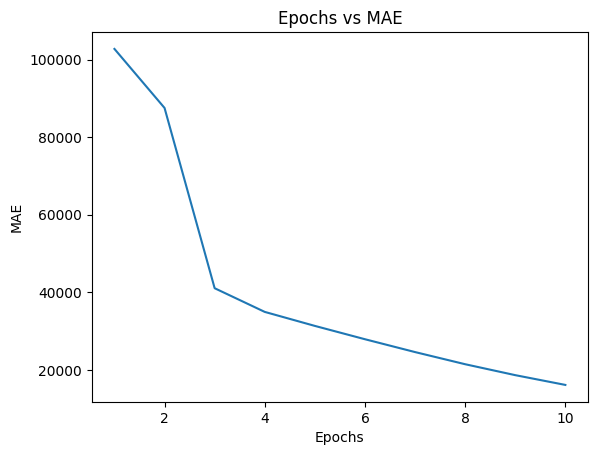

In [ ]:
mae = history.history['mean_absolute_error']

epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, label='Training MAE')

plt.title('Epochs vs MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')

plt.show()

In [ ]:
# the predition is list of list, in order to use the utility function, transfer into a single list
preds = model.predict(X_test)
preds = [pred[0] for pred in preds]
preds[0:5]

[136515.11, 101261.016, 175348.66, 96356.234, 113481.45]

Similar to our other two models, we want to plot the comparison of the predicted salaries of our best models to their target predictions. 

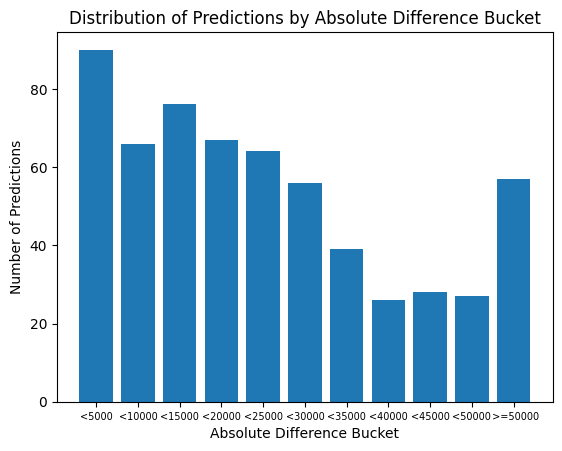

In [ ]:
utility.plot_accuracy_in_buckets(y_test, preds)